<a href="https://colab.research.google.com/github/MaiNga-uit/CS2224.CH1501/blob/main/codeBook/ContentBasedImageRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Prepare data:
Run 3 code blocks below to:
- Download & extract the oxford builds dataset from website
- Download the utils file - this file is prepared and was uploaded to google drive for easy to use (and it's also used in the web project on github)



In [ ]:
import gdown
!mkdir '/content/dataset/'
datasetUrl = 'https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/oxbuild_images.tgz'
downloadFolder = '/content/dataset/oxbuild_images.tgz' 
gdown.download(datasetUrl, downloadFolder, quiet=False)

utilFilesUrl = 'https://drive.google.com/uc?id=1HTa7tTOA5KmKUpdTLNSIxBtf330pdmVV'
savedDir = '/content/DeepImageUtils.py'
gdown.download(utilFilesUrl, savedDir, quiet=False)

In [ ]:
import os, sys, tarfile

def extract(tar_url, extract_path='.'):
    # print tar_url
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])
try:

    extract(sys.argv[1] + '.tgz')
    # print 'Done.'
except:
    name = os.path.basename(sys.argv[0])
    # print name[:name.rfind('.')], '<filename>'

In [ ]:
extract('/content/dataset/oxbuild_images.tgz', '/content/dataset')
!rm '/content/dataset/oxbuild_images.tgz'

# Step 2: Construct the feature database
- Purpose: to use for build the image system retrieval
- Construct flow as below:
  * Step 2.1: Classify the images in dataset into categories, and store its into category folders. In this step, we used the Inception Resnet v2 pre-trained model (which was built on imagenet, can classify 1000 classes)
  * Step 2.2: Extract the features for images in each category and store into the *.npz file. In this step, we used the Inception Resnet v2 as base model (without fully connected layer) to extracted the features

- After run follow the above steps, we will have the features (*.npz file), which is stored in the catefory folders (each .npz file is representation for each category).
- And the *.npz files (the feature files) will be used as the database for the image retrieval system)









In [ ]:
from shutil import copyfile
import os
import numpy as np
import DeepImageUtils as IU
from scipy.spatial import distance
from matplotlib import pyplot as plt

In [ ]:
def MakeDirChecked(path):
    if not os.path.isdir(path):
        os.mkdir(path)

In [ ]:
root_folder = '/content/dataset'

database_path = input('Enter the path to create the root folder of the database in: \n')
database_path = os.path.join(database_path, 'database')
database_path = os.path.realpath(database_path)

Enter the path to create the root folder of the database in: 
/content/


In [ ]:
# get the path to all image files in the root folder
image_paths = IU.GetAllImagesInPath(root_folder)

# the root create database folder
MakeDirChecked(database_path)
for img_path in image_paths:
    # predict the categories of every image in the dataset 
    categories = IU.PredictImageCategory(img_path)
    print(categories)
    # create a folder for every category to easily separate the data reducing search times
    for category in categories:
        category_path =  os.path.join(database_path, category) + '/'
        # create the directory for the category
        MakeDirChecked(category_path)
        # copy the image to the category folder
        # could potentially just save the extracted features there and have a reference to the place of the orignal image path
        # having a reference might help with avoiding duplicates and copy times if you don't need a backup
        # and if you are scapping the web you can just link to the original image in the features database to retrun that link later
        copy_path = os.path.join(category_path, IU.Path2Name(img_path))
        copyfile(img_path, copy_path)

In [ ]:
import DeepImageUtils as IU

# get all the created category folders in the database directory
category_folders = IU.GetAllFolderInPath('/content/drive/MyDrive/ImageRetrievalProject/database')
# for every category create the feature vector for the images of that category present in the category file
for category_folder in category_folders:
    if category_folder == '/content/drive/MyDrive/ImageRetrievalProject/database/':
        continue
    if category_folder == '/content/drive/MyDrive/ImageRetrievalProject/database/database/':
      continue

    feature_vectors = []
    # get all image file paths' in the category's folder
    database_image_paths = IU.GetAllImagesInPath(category_folder)
    print(category_folder)
    print(database_image_paths)
    # extract the features of each image and append it to the feature list of that category
    # this is where you would put the link or the other path of the image instead of the local one
    for database_image_path in database_image_paths:
        img_features = [database_image_path, IU.CreateImageFeaturesVector(database_image_path)]
        feature_vectors.append(img_features)  
  
    # save the features as a compressed numpy array object with the name of the category
    feature_file_name = IU.Path2Name(category_folder[:-1]) + '.npz'
    # features_path = os.path.join(category_folder, feature_file_name)
    features_path = os.path.join(category_folder, feature_file_name)
    np.savez_compressed(features_path, feature_vectors)
    print("Done save!")

# Testing:
* In google colab, we just support testing for a whole image
* To query by region of image, please visit the github: https://github.com/MaiNga-uit/CS2224.CH1501

In [ ]:
query_img_path = input('Enter query image path:\n')
query_img_path = os.path.realpath(query_img_path)

if not os.path.isfile(query_img_path):
    print('No such file:', query_img_path)
    exit(1)

In [ ]:
query_img_categories = IU.PredictImageCategory(query_img_path)
img_features_vector = IU.CreateImageFeaturesVector(query_img_path)
print(query_img_categories)
print(len(img_features_vector))

feature_vectors = []
for category in query_img_categories:
    category_path = os.path.join(database_path, category, category + '.npz')
    
    if not os.path.isfile(category_path):
        continue

    loaded_feature_vectors = np.load(category_path, allow_pickle=True)
    loaded_feature_vectors = list(loaded_feature_vectors['arr_0'])
    # only add every image once (using the image name as a reference since that shouldn't be duplicated)
    for loaded_feature_vector in loaded_feature_vectors:
        if IU.Path2Name(loaded_feature_vector[0]) in (IU.Path2Name(feature_vector[0]) for feature_vector in feature_vectors):
            continue
      
        feature_vectors.append(loaded_feature_vector)

if not feature_vectors:
    print('No results')
    # Display original image and exit script
    plt.figure()
    query_img = IU.OpenImage(query_img_path)
    plt.axis('off')
    plt.title('No results')
    plt.imshow(query_img)
    plt.show()
    exit()

In [ ]:
# Similarity calculate: using cosine distance
feature_vectors.sort(key=lambda feature_vector: distance.cosine(feature_vector[1], img_features_vector))

In [ ]:
def GetTilteforMatchingImage(i):
    i = str(i)
    if i.endswith('1'):
        return i + 'st matching image'
    if i.endswith('2'):
        return i + 'nd matching image'
    if i.endswith('3'):
        return i + 'rd matching image'
    
    return i + 'th matching image'

['/content/drive/MyDrive/ImageRetrievalProject/database/mortarboard/keble_000206.jpg'
 array([0.01561916, 0.00348145, 0.0545622 , ..., 0.00292103, 0.00010058,
       0.00051159], dtype=float32)]


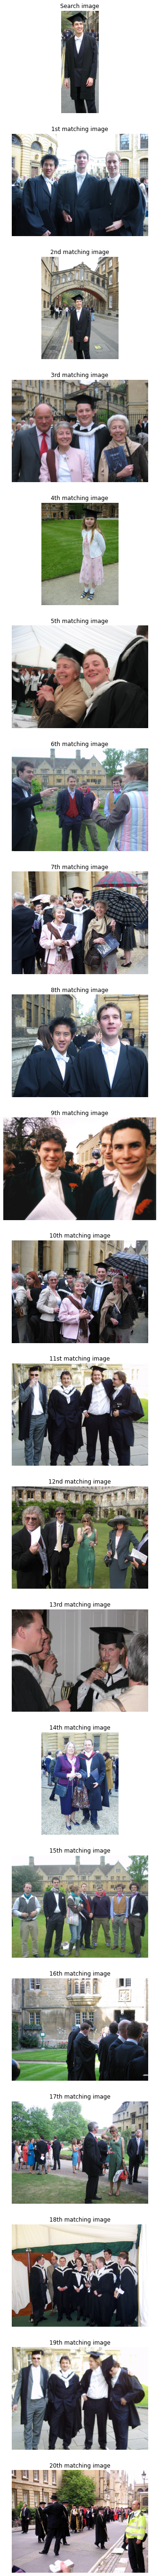

In [ ]:
import cv2 as cv

n_matching_images_to_show = 20
n_cols = 1
n_rows = 21

# Display all results, alongside original image
results_figure=plt.figure(figsize=(100,100))

query_img = IU.OpenImage(query_img_path)

results_figure.add_subplot(n_rows, n_cols, 1)
plt.axis('off')
plt.title('Search image')
plt.imshow(query_img)
print(feature_vectors[0]);

# show the selected number of closest images
if n_matching_images_to_show > n_rows * n_cols:
    n_matching_images_to_show = n_rows * n_cols

if n_matching_images_to_show > len(feature_vectors):
    n_matching_images_to_show = len(feature_vectors)
else:
    feature_vectors = feature_vectors[:n_matching_images_to_show]

for i in range(0, n_matching_images_to_show):
    results_figure.add_subplot(n_rows, n_cols, i+2)
    plt.axis('off')
    plt.title(GetTilteforMatchingImage(i+1))
  
    img = IU.OpenImage(feature_vectors[i][0])
    plt.imshow(img)

plt.show()